In [9]:
import torch
from manopth.manolayer import ManoLayer
from manopth import demo
import numpy as np
import matplotlib.pyplot as plt

from PSO import *

from deodr.pytorch import CameraPytorch,Scene3DPytorch
from deodr.pytorch import TriMeshPytorch as TriMesh

def Generate_Random_hand(ncomps=6,center_idx=-1, use_pca=True,batch_size=1):
    mano_layer = ManoLayer(mano_root='mano/models',side="right",center_idx=center_idx, use_pca=use_pca, ncomps=ncomps)
    random_shape = torch.rand(batch_size, 10)*2
    random_pose = torch.rand(batch_size, ncomps + 3)
    hand_verts, hand_joints = mano_layer(random_pose, random_shape)
    return hand_verts,hand_joints,mano_layer.th_faces,random_pose,random_shape


class GraphicsRenderer:
    def __init__(self,height=480,width=640,intrinsic=np.array([[1, 0, 0. ], [0, 1, 0 ], [0, 0, 1.]]),
        extrinsic=np.array([[ 1.,  0.,  0., -0.], [ 0., 1.,  0., -0.],[ 0.,  0., 1.,  0]])):
        # this class, given a mesh, it renders it
        self.intrinsic=intrinsic
        self.extrinsic=extrinsic
        self.width=width
        self.height=height
        self.camera=CameraPytorch(extrinsic=extrinsic,intrinsic=intrinsic,width=width,height=height,distortion=None)
        self.scene = Scene3DPytorch()

    def render(self,vertices,faces,max_depth=0,depth_scale = 1):
        # vertices is torch.tensor of size (n,3), faces is a torch.tensor of size (m,3)
        self.mesh = TriMesh(  faces.numpy().copy() )
        self.scene.set_mesh(self.mesh)
        self.scene.max_depth = max_depth
        self.scene.set_background(np.full((self.height, self.width, 1), max_depth, dtype=np.float))
        self.mesh.set_vertices(vertices.double())

        depth = self.scene.render_depth(self.camera, width=self.width, height=self.height, depth_scale=depth_scale)
        return depth

    
def Normalize(vertices,hand_joints,scale=0.6,translate=torch.tensor([0,0,1])):
       # vertices is torch.tensor of size (n,3), faces is a torch.tensor of size (m,3)
       # hand_joints is of shape (m,3)
               
        Mins=torch.min(vertices.double(),dim=0)[0];Mins[2]=Mins[2]-1
        r=(torch.squeeze(vertices.double())-Mins)
        verts=r*scale+translate
               
        joints=hand_joints.double()-Mins
        joints=joints*scale+translate
        
        return verts,joints
    
def compute_center(img_inp,max_depth=0):
    # img is a tensor of size (h,w)
    img_inp=img_inp.squeeze()
    X,Y=torch.where(img_inp!=max_depth)
    X_mean=torch.mean(X.float())
    Y_mean=torch.mean(Y.float())
    return (X_mean,Y_mean)

def compute_IOU(inp1,inp2,max_depth=-32):
    # both are tensor of size (1,h,w)
    rend1=inp1.clone();rend2=inp2.clone()
    mask1=rend1!=max_depth
    mask2=rend2!=max_depth
    return torch.sum(torch.logical_and(mask1,mask2)).double()/torch.sum(torch.logical_or(mask1,mask2))

In [2]:
# create the hand synthesizer
max_depth=0
global_scale=0.65
renderer=GraphicsRenderer(height=128,width=128)

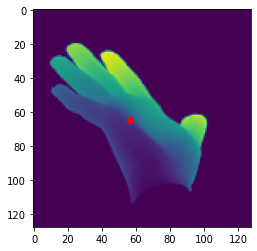

In [8]:
# randomly generate a hand and plot it, this will be the ground-truth for the optimization problem

hand_verts,hand_joints,mano_faces,pp,sh=Generate_Random_hand()
verts,joints=Normalize(hand_verts[0],hand_joints[0],translate=torch.tensor([10,20,1]),scale=global_scale)
IMG=renderer.render(verts,mano_faces,max_depth=max_depth)

xxx,yyy=compute_center(IMG,max_depth)
plt.imshow(np.squeeze(IMG.detach()))
plt.scatter(yyy,xxx,c="red")


In [10]:
ncomps=6
mano_layer = ManoLayer(mano_root='mano/models',side="right",center_idx=-1, use_pca=True, ncomps=ncomps)

MSE=torch.nn.L1Loss()

def cost(x):
    
    shape=sh
    pose=torch.from_numpy(x[0,0:(ncomps + 3)].reshape(1,-1)).float()
    trans=torch.from_numpy(x[0,(ncomps + 3):(ncomps + 3 +2)].reshape(1,-1)).float()
    
    hand_verts, hand_joints = mano_layer(pose, shape)
    verts,joints=Normalize(hand_verts[0],hand_joints[0],translate=torch.tensor([trans[0,0],trans[0,1],0]),scale=global_scale)
    img=renderer.render(verts,mano_faces,max_depth=max_depth)
    
    reconstruction_loss=MSE(IMG,img).numpy()
    shape_loss=torch.norm(shape).item()
    pose_loss=torch.norm(pose).item()
    iou_loss=1-compute_IOU(img,IMG,max_depth).item()
    loss= 4*iou_loss+reconstruction_loss+pose_loss
    return loss


dim=(ncomps+3 + 3) # dimension of each particle

center_x,center_y=compute_center(IMG)
nit=np.random.rand(1,dim);nit[0,-2]=center_x.numpy();nit[0,-1]=center_y.numpy(); # initialize particles

Optimizer=PSO(num_dimensions=dim,lower_bound=-2,higher_bound=30,num_particles=128,ini=nit)


In [12]:
Optimizer.optimize(cost,70)

iter 0, best error= 16.264126997951315
iter 1, best error= 9.656670347773685
iter 2, best error= 9.656670347773685
iter 3, best error= 9.324627055934883
iter 4, best error= 7.99274863718351
iter 5, best error= 7.99274863718351
iter 6, best error= 7.99274863718351
iter 7, best error= 7.99274863718351
iter 8, best error= 7.972054743901783
iter 9, best error= 7.839868019602491
iter 10, best error= 7.362933466319116
iter 11, best error= 6.96384443270011
iter 12, best error= 6.96384443270011
iter 13, best error= 6.96384443270011
iter 14, best error= 6.925048648599025
iter 15, best error= 6.923732032672449
iter 16, best error= 6.891349708401343
iter 17, best error= 6.880998329939749
iter 18, best error= 6.855053440518354
iter 19, best error= 6.855053440518354
iter 20, best error= 6.855053440518354
iter 21, best error= 6.855053440518354
iter 22, best error= 6.855053440518354
iter 23, best error= 6.855053440518354
iter 24, best error= 6.855053440518354
iter 25, best error= 6.855053440518354
it

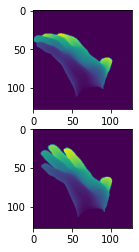

In [19]:
final_solution=Optimizer.pos_best_g
pose=torch.from_numpy(final_solution[0,:(ncomps + 3)].reshape(1,-1)).float()
trans=torch.from_numpy(final_solution[0,(ncomps + 3):(ncomps + 3 +2)].reshape(1,-1)).float()
hand_verts, hand_joints = mano_layer(pose, sh)
verts,joints=Normalize(hand_verts[0],hand_joints[0],translate=torch.tensor([trans[0,0],trans[0,1],0]),scale=global_scale)
img=renderer.render(verts,mano_faces)

plt.subplot(2,1,1)
plt.title("Ground-Truth Image")
plt.imshow(np.squeeze(img).detach())
plt.subplot(2,1,2)
plt.imshow(np.squeeze(IMG.detach()))
plt.title("Ground-Truth Image")


In [17]:
img.shape

torch.Size([128, 128, 1])